In [2]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
#from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from textparser import TextParser
import nltk

## Vectorizing tutorial

In [2]:
raw = pd.read_csv('nrao_projects.csv')
raw.head()

,project_code,project_title,project_abstract,fs_type,target
0,2018.1.01205.L,Fifty AU STudy of the chemistry in the disk/en...,The huge variety of planetary systems discover...,line,1
1,2022.1.00316.L,COMPASS: Complex Organic Molecules in Protosta...,The emergence of complex organic molecules in ...,line,1
2,2017.1.00161.L,ALCHEMI: the ALMA Comprehensive High-resolutio...,A great variety in gas composition is observed...,line,1
3,2021.1.01616.L,ALMA JELLY - Survey of Nearby Jellyfish and Ra...,We propose the first ever statistical survey o...,line,1
4,2021.1.00869.L,Bulge symmetry or not? The hidden dynamics of ...,A radio survey of red giant SiO sources in the...,line,1


In [3]:
raw['text'] = raw.project_title.str.strip() + ' ' + raw.project_abstract.str.strip()    # strip leading or trailing spaces
raw['text'] = raw.text.str.lower()                                                      # convert to lower case

In [4]:
raw = raw.drop(['project_code', 'project_title', 'project_abstract', 'fs_type'], axis=1)

In [5]:
NGRAM_RANGE = (1, 10)
TOP_K = 20000
TOKEN_MODE = 'word'
MIN_DOC_FREQ = 1

tfidf_vectorizer = TfidfVectorizer()
x_train = tfidf_vectorizer.fit_transform(raw['text'].astype('U'))

In [6]:
test = pd.DataFrame(tfidf_vectorizer.get_feature_names_out())

In [7]:
test[1989:]

,0
1989,abandance
1990,abandunce
1991,abcs
1992,abell
1993,aberrant
...,...
14530,zyjhk
14531,µjy
14532,µm
14533,λcdm


In [8]:
#convert to lowercase, strip and remove punctuations
def preprocess(text):
    text = text.lower()
    text=text.strip()  
    text=re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    return text
 
# STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)

#LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

# Notes
## Text Standardization
* Respect and build thoughtful OHCO for overall text model

### Tentative Language Model Deliverable
* LIB table (collection of proposal IDs, titles, abstracts, title+abstract, possible classification but maybe this could be reseved for a different table)
* DOC table (gather from token table)
* TOKEN table ()
* VOCAB table ()

### OHCO Outline
* Combine title and abstract
* Corpus is built of combined titles and abstracts, i.e. all proposal titles and abstracts
* Treat combined title and abstract as document
* **CURRENTLY IT APPEARS AS THOUGH ABSTRACTS ARE FORMATTED TO ONE LARGE PARAGRAPH THOUGH THIS REQUIRES EDA CONFIRMATION**
* **IT APPEARS AS THOUGH TITLES ARE ONE SENTENCE BUT THIS REQURES EDA CONFIRMATION**
* Combine title and abstract on specific (unique) character to ensure full title is first sentence of document
* THIS GIVES THE FOLLOWING OHCO
    * CORPUS (all projects)
    * DOCUMENT (individual project, title and abstract combined)
    * SENTENCE (title is first sentence, abstract are following sentences)
    * TOKEN (see notes below on tokenization)

### Tokenization notes
* What to do with numbers?
* Lower case everything
* Strip leading and trailing space

## Language Model

### LIB Table

In [3]:
LIB = pd.read_csv('nrao_projects.csv')
LIB['project_title_abstract'] = LIB['project_title'] + ". " + LIB['project_abstract']
LIB['project_title_abstract'] = LIB['project_title_abstract'].astype(str)
LIB = LIB.drop(['fs_type', 'target'], axis=1)
LIB.head()

,project_code,project_title,project_abstract,project_title_abstract
0,2018.1.01205.L,Fifty AU STudy of the chemistry in the disk/en...,The huge variety of planetary systems discover...,Fifty AU STudy of the chemistry in the disk/en...
1,2022.1.00316.L,COMPASS: Complex Organic Molecules in Protosta...,The emergence of complex organic molecules in ...,COMPASS: Complex Organic Molecules in Protosta...
2,2017.1.00161.L,ALCHEMI: the ALMA Comprehensive High-resolutio...,A great variety in gas composition is observed...,ALCHEMI: the ALMA Comprehensive High-resolutio...
3,2021.1.01616.L,ALMA JELLY - Survey of Nearby Jellyfish and Ra...,We propose the first ever statistical survey o...,ALMA JELLY - Survey of Nearby Jellyfish and Ra...
4,2021.1.00869.L,Bulge symmetry or not? The hidden dynamics of ...,A radio survey of red giant SiO sources in the...,Bulge symmetry or not? The hidden dynamics of ...


In [5]:
Lang_model = TextParser(LIB)

In [6]:
CORPUS = Lang_model.parse_tokens()
VOCAB = Lang_model.extract_vocab(True, 'none')
CORPUS.head()

Done


NameError: name 'TOKENS' is not defined

In [6]:
VOCAB.sample(350)

,n,n_chars,p,i,n_pos_group,cat_pos_group,n_pos,cat_pos,stem_porter,stem_snowball,stem_lancaster
term_str,,,,,,,,,,,
qualitative,1,11,0.000001,19.715406,1,{JJ},1,{JJ},qualit,qualit,qualit
concluding,1,10,0.000001,19.715406,1,{VB},1,{VBG},conclud,conclud,conclud
hylirgs,13,7,0.000015,16.014966,2,"{NN, VB}",3,"{NN, NNP, VBP}",hylirg,hylirg,hylirg
spiral,349,6,0.000405,11.268322,3,"{NN, JJ, VB}",5,"{NN, NNS, VBD, JJ, NNP}",spiral,spiral,spir
photoionising,2,13,0.000002,18.715406,2,"{NN, VB}",2,"{NNP, VBG}",photoionis,photoionis,photo
...,...,...,...,...,...,...,...,...,...,...,...
legacy,98,6,0.000114,13.100696,1,{NN},2,"{NN, NNP}",legaci,legaci,leg
ccsne,4,5,0.000005,17.715406,1,{NN},2,"{NN, NNP}",ccsne,ccsne,ccsne
vertically,5,10,0.000006,17.393478,2,"{NN, RB}",2,"{NN, RB}",vertic,vertic,vert


In [8]:
CORPUS.shape

(861689, 5)

In [10]:
# Average number of words per title + abstract
CORPUS.shape[0] /LIB.shape[0] 

190.30234098939928

In [11]:
CORPUS[CORPUS.term_str == ''].token_str.value_counts()

token_str
=        185
>        154
~        147
&        133
<        123
+         49
/         26
(~        26
(<        22
(>        15
*         13
?.        11
%         11
),        10
–          8
>=         4
(=         3
%)         3
×          3
+/         3
∼          2
−          2
~<         2
(>>        2
(!!).      2
—          2
(+/        2
].         1
(!)        1
(<=        1
...),      1
[          1
],         1
>>         1
~>         1
);         1
))         1
@          1
(~<        1
>~         1
$>         1
(+         1
<~         1
($<$       1
($>$       1
$<         1
($<        1
[...       1
Name: count, dtype: int64

## Add Bagging and TF-IDF

In [7]:
Bag=Lang_model.corp_to_BOW()
TFIDF=Lang_model.BOW_TFIDF('sum')

In [8]:
TFIDF.head()

n        tf     tfidf
project_code   term_str                         
2011.0.00010.S 12cm        1  0.003922  0.047626
               7mm         1  0.003922  0.037489
               a           8  0.031373  0.003006
               absorption  3  0.011765  0.052615
               agn         1  0.003922  0.012094

## Interlude: Stopword Stats

In [23]:
sw = pd.DataFrame(nltk.corpus.stopwords.words('english'), columns=['term_str'])
sw = sw.reset_index().set_index('term_str')
sw.columns = ['dummy']
sw.dummy = 1

In [24]:
VOCAB_POS['stop'] = VOCAB_POS.index.map(sw.dummy)
VOCAB_POS['stop'] = VOCAB_POS['stop'].fillna(0).astype('int')

In [25]:
a = VOCAB_POS.groupby('stop').n_chars.mean()
b = VOCAB_POS.groupby('stop').n_pos.mean().sort_values(ascending=False)

In [26]:
pd.concat([a,b], axis=1)

,n_chars,n_pos
stop,,
0,7.127717,1.721405
1,3.584746,5.008475


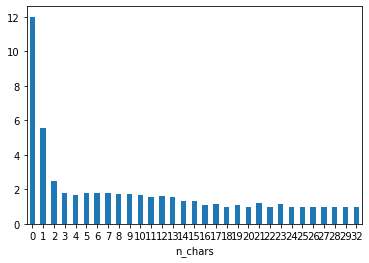

In [27]:
VOCAB_POS.groupby('n_chars').n_pos.mean()\
    .sort_index().plot.bar(rot=0);

In [28]:
VOCAB_POS[VOCAB_POS.stop == True].sort_values('n_pos', ascending=False)[['n_pos','cat_pos']].head(20)

,n_pos,cat_pos
term_str,,
a,13,"{IN, RB, VBD, RP, PDT, NNS, DT, VBN, NNP, VBP,..."
or,13,"{VBZ, IN, RP, VBD, PDT, NNS, VBN, NNP, VBP, VB..."
i,13,"{IN, RB, VBD, PRP, PDT, VBN, NNP, RBR, VBP, VB..."
that,12,"{IN, RB, VBD, WDT, JJ, NNS, WP, VBP, VB, NN, V..."
and,12,"{IN, VBZ, RB, VBD, NNS, VBN, NNP, VBP, VB, NN,..."
with,10,"{IN, CD, VBD, NNP, JJR, NNS, VBP, NN, VBZ, JJ}"
the,10,"{RB, VBD, FW, NNS, DT, NNP, VBP, NN, VBZ, JJ}"
so,10,"{RB, IN, VBD, WDT, VBN, NNP, VBP, VB, NN, JJ}"
to,10,"{RB, IN, VBD, NNP, NNS, TO, VBP, VB, NN, JJ}"
